# Surface profile and flow field

When putting a porous biomaterial in a thin liquid film, we observe a rim around the material. This rim looks differently from both the rest of the thin liquid film and the porous material. It seems that in this rim, there is less dye. It also seems that the liquid film thickness does not change monotonically near this rim. A snapshot of this rim is shown below:

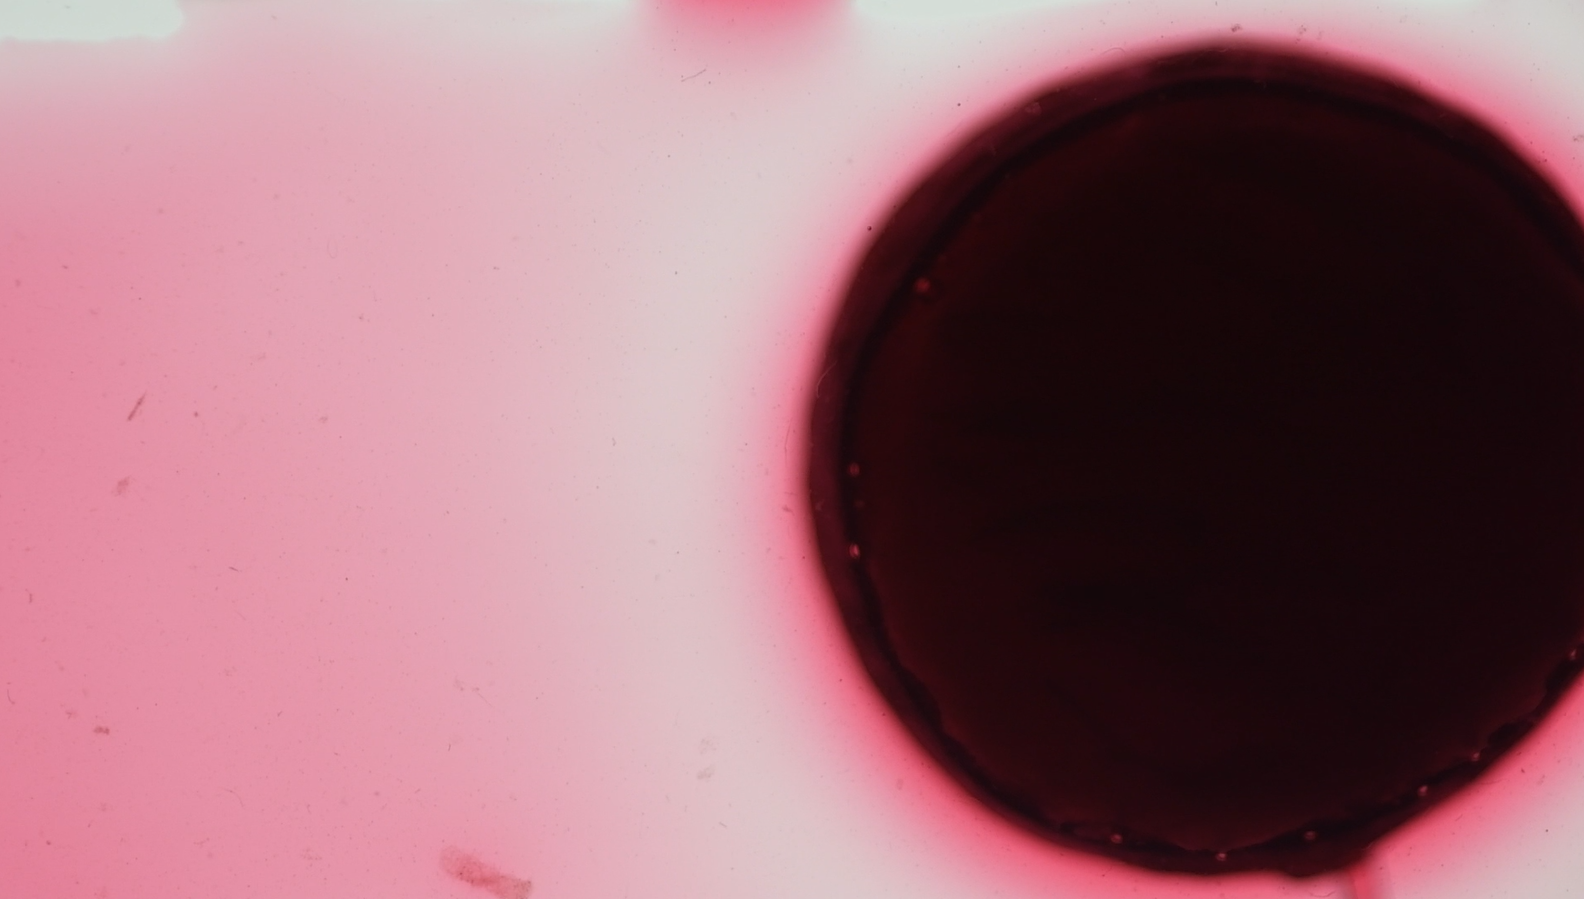

We want to understand the formation mechanism of this rim. Our hypothesis is that there is a dimple in the radial liquid surface profile, which leads to 
- thinner liquid film and in turn less amount of dye;
- curved surface that reflects light differently than flat one.
The two effects makes the rim particularly obvious to our eyes.

To test our hypotheses, I set up an experiment to measure the surface profile of the thin film around the rim. The surface measurement takes advantage of the [Keyence confocal displacement sensor](https://www.keyence.com/products/measure/laser-1d/cl-3000/) mounted on a motorized linear stage. At the same time, we use a Nikon DSLR camera to image the process of the rim formation, in the hope of extracting the flow field associated in this process. The setup is shown in the picture below.

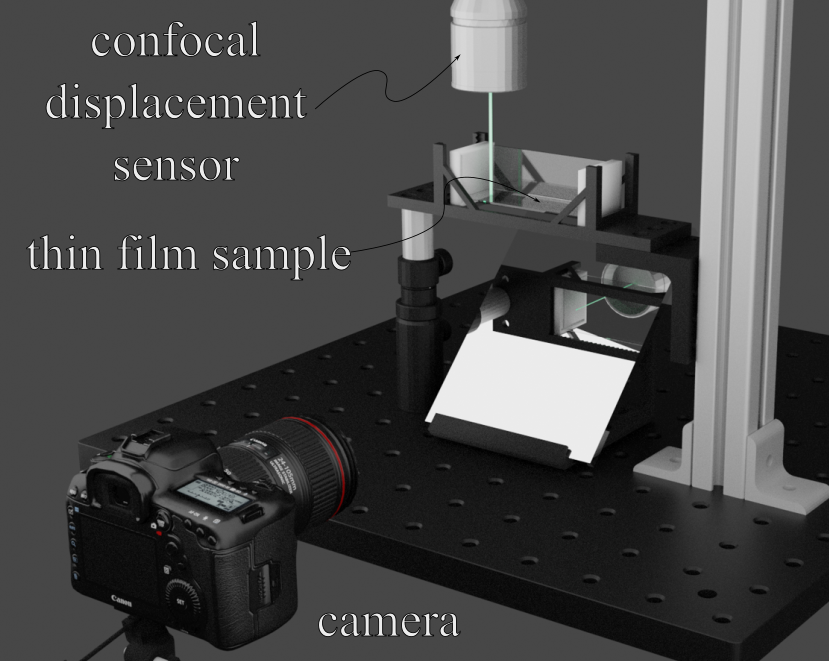

This measurement generates two raw data for each sample scan: 
- a text file of surface height vs. time (.csv);
- a bottom-view video of the scan process (.mov). 

Some postprocessing is required for the raw data:
- convert [surface height vs. time] to [surface height vs. horizontal position x];
- part of the surface height data is out of the liquid film region / out of the measurement range, which needs to be trimmed;
- synchronize the video with the scan, create a new video (like the [demo](https://drive.google.com/open?id=1LuXQMlca6CWQPx2JYWURytDooj1HmHBV&usp=drive_fs));
- measure the flow field using particle tracking velocimetry.

In this notebook, I demonstrate the postprocessing procedures. The expected outputs are:
- surface profile: a table of surface height vs. x, the file should correspond to the raw data file, but the surface height data should be trimmed and converted.
- scan demo: simultaneously display scan images and height results.

## 0 Packages and settings

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'

## 1 Surface profile

In this section, we prepare the surface profile table from the raw .csv data.

### 1.1 Load surface height data

Text(0, 0.5, 'Surface height (mm)')

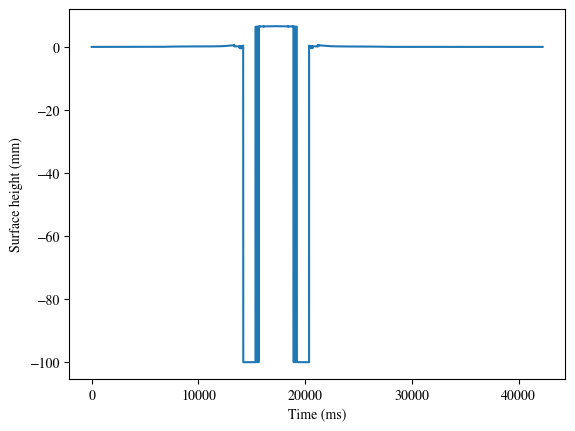

In [6]:
folder = r"E:\WPM\04292024"
filename = "beet_scan_1"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")

The meaningful measurement is usually between 0 and 0.3 mm. The big rise or drop of the data is typically due to the distance being measured is out of range.

### 1.2 Trim the scan data

Trimming the raw scan data in Jupyter notebook is possible but slow because plots in Jupyter notebook does not allow free zooming and panning. Therefore, it is recommanded to use the script `examine_scan.py` view the raw scan data and to locate the "keyframes" of the scans in the raw data. Record the indices of those keyframes of multiple raw data files in one .csv file, and then we can trim the raw data with the keyframes information at once.

For example, we run the script and zoom in to see the following scan curve. We first identify the start and end points of the scan. Typically, starting point is where the height value just starts to deviate from 0, and the end point is the highest point of the smooth part. We usually scan back and forth for more time resolved data. In the keyframe recording, we differentiate the forward and backward scans by labels "f" and "b". Then, in each file, we typically have multiple scans of the same surface, we also label an integer on each scan to differentiate them. Lastly, we label the raw data file name to each entry, so we know where to perform the trimming.

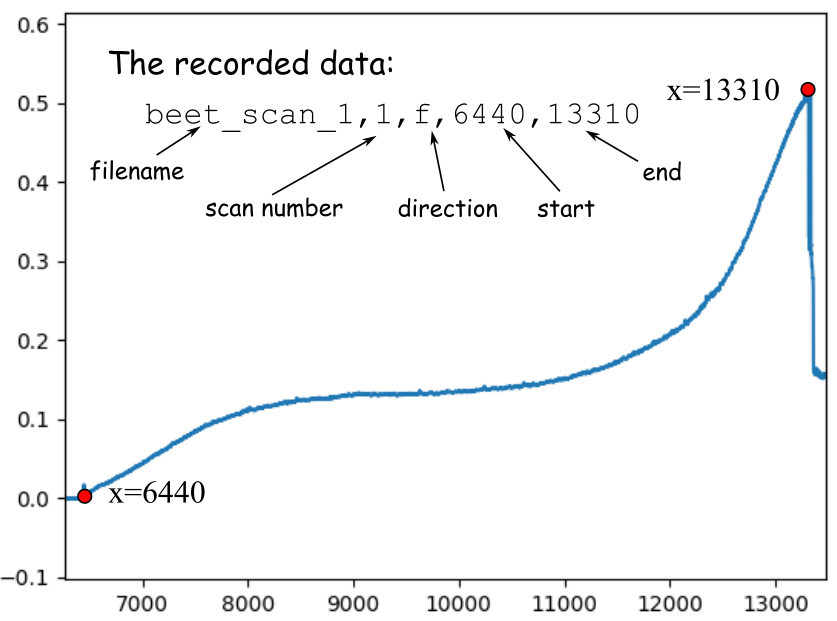


### 1.3 Convert to surface profile

With this keyframe labeling system, we can process multiple raw data files, and record the keyframes in a separate file, then use the numbers in this file to trim all the data in one run. This keyframe data file, "keyframes.csv", looks like this:

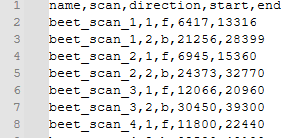

The following code extracts the surface profiles from raw scan data, based on the "keyframes.csv" data we just constructed.

In [21]:
######## set parameters here ##########
data_folder = r"E:\WPM\04292024" # raw data folder
v = 1.6 # mm/s, I set it constant for now, but later this can be improved by measuring the speed for each specific scan
fps_data = 1000 # the frequency of the Keyence confocal sensor readout, typically 1000
#######################################

save_folder = os.path.join(data_folder, "surface_profile") # folder to save processed data
if os.path.exists(save_folder) == False:
    print("Save folder does not exist, creating ...")
    os.makedirs(save_folder)

keyframes = pd.read_csv(os.path.join(data_folder, "keyframes.csv"))

for name, scans in keyframes.groupby("name"):
    surface = pd.read_csv(os.path.join(data_folder, "{}.csv".format(name)), usecols=[1], skiprows=12, names=["height"])
    scans_list = []
    for num, i in scans.iterrows():
        # print("Processing file {0}: scan {1:d}".format(name, i.scan))
        scan = surface[i.start: i.end].copy()
        if i.direction == "f":
            scan["x"] = np.flip(np.arange(len(scan))) / fps_data * v
        else:
            scan["x"] = np.arange(len(scan)) / fps_data * v 
        scan.sort_values(by=["x"], inplace=True)
        # plt.plot(scan["x"], scan["height"])
        scans_list.append(scan.set_index("x").rename(columns={"height": "scan-{:d}".format(i.scan)}))
    print("Writing {}.csv".format(name))
    pd.concat(scans_list, axis=1).to_csv(os.path.join(save_folder, "{}.csv".format(name)))

Writing beet_scan2_1.csv
Writing beet_scan2_2.csv
Writing beet_scan2_3.csv
Writing beet_scan3_1.csv
Writing beet_scan3_2.csv
Writing beet_scan3_3.csv
Writing beet_scan4_1.csv
Writing beet_scan4_2.csv
Writing beet_scan4_3.csv
Writing beet_scan4_4.csv
Writing beet_scan_1.csv
Writing beet_scan_2.csv
Writing beet_scan_3.csv
Writing beet_scan_4.csv
Writing beet_scan_5.csv


### 1.4 Plot the surface profiles

With the organized surface profiles, we can plot them easily. The most informative way of plotting the surface profiles I found is to plot all the repeated scans in one axis. This way we can observe the temporal evolution of the film. We can also put films of different thicknesses together, which allows us to assess the thickness effect.

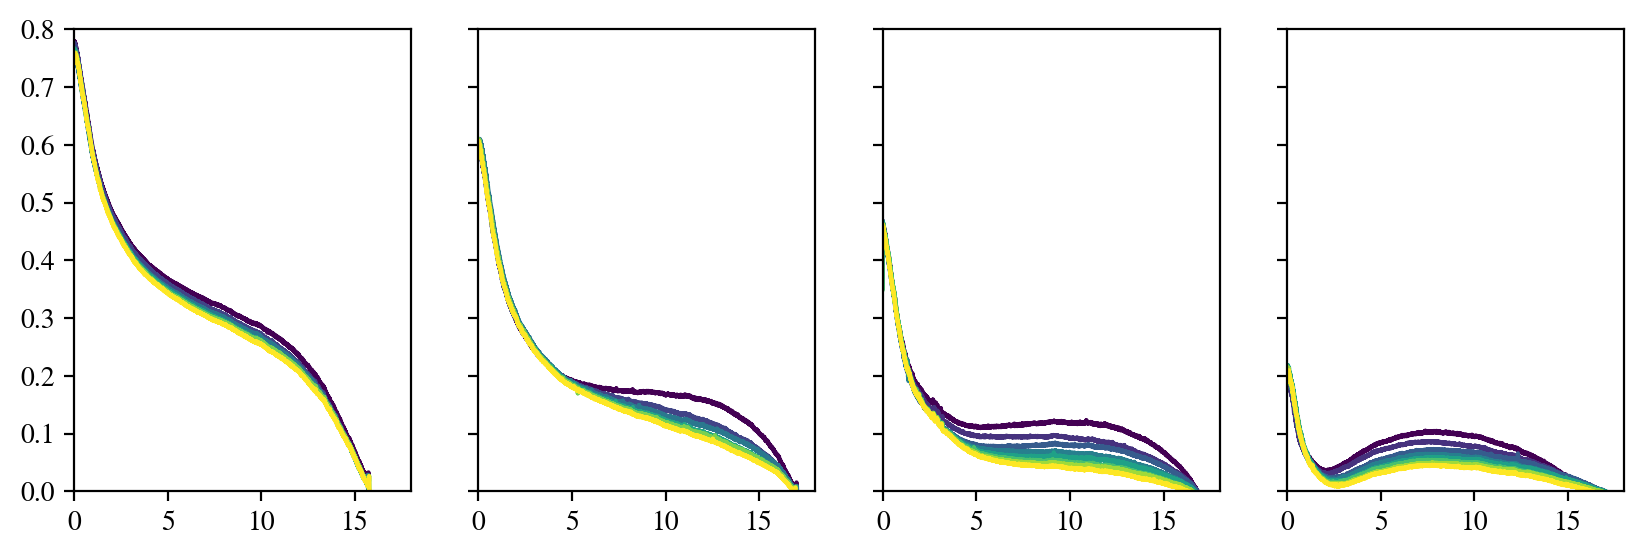

In [ ]:
folder = r"E:\WPM\04292024\surface_profile"
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(10,3), dpi=200)
for j in range(4):
    df = pd.read_csv(os.path.join(folder, "beet_scan4_{:d}.csv".format(j+1))).set_index("x")
    cmap = plt.get_cmap("viridis", df.shape[1])
    i = 0
    for scan in df:
        ax[j].plot(df.index, df[scan], color=cmap(i), label=i)
        i += 1
        ax[j].set_xlim([0,18])
        ax[j].set_ylim([0,0.8])
    # ax[j].legend(frameon=False)


## 2 Display surface scan and video simultaneously

Making a video out of the surface height data and play together with the bottom-view video help to check the surface height data validity, and also help in understanding the surface height data. In this section, we use the processed surface profile data and the bottom view video to generate the simultaneous display, as shown below:

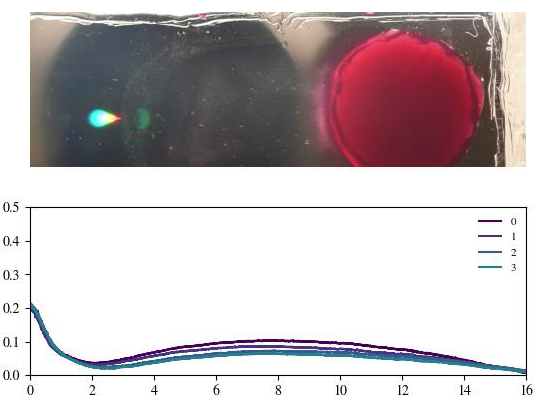

### 2.1 Synchronize raw scan data and video

Open video in MPC and find the first and last moments when laser touches the liquid film. For example, for the file 04292024/beet_scan4_3.MOV, first moment is 00:20.887 and last moment is 02:39.425. In the raw scan data, these two times corresponds to the beginning of the first scan and then end of the last scan, which can be read from the keyframes.csv file: 11797 and 151029. 

In a typical experiment, I start imaging first and then the scan data recording. So we can use linear extrapolation to get the time in the video that corresponds to the starting point of the scan data. 

In [26]:
####### set parameters here ########
v_1 = 20.887
v_2 = 159.425
s_1 = 11797
s_2 = 151029
####################################
v_0 = v_1 - s_1 * (v_2 - v_1) / (s_2 - s_1)
print("Scan data recording starts at {:.3f} s in the video.".format(v_0))

Scan data recording starts at 9.149 s in the video.


### 2.2 Generate images

Use the v_0 calculated in the previous section to register surface scan data and the video. Generate synchronized images. 

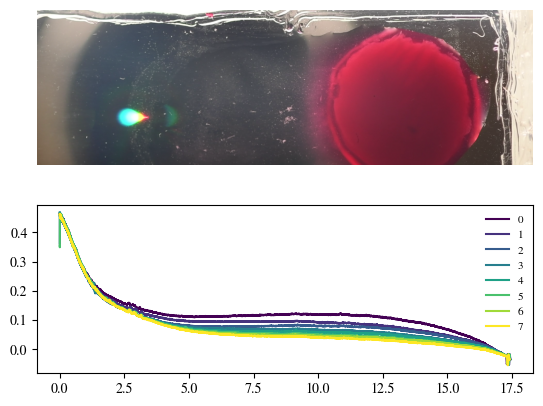

In [29]:
####### set parameters here ###########
data_folder = r"E:\WPM\04292024"
file_name = "beet_scan4_3"
interval = 10 # save image every certain frames
fps_data = 1000 # the frequency of the Keyence confocal sensor readout, typically 1000
#######################################

cap = cv2.VideoCapture(os.path.join(data_folder, file_name + ".MOV"))
data = pd.read_csv(os.path.join(data_folder, "surface_profile", file_name + ".csv"))
keyframes = pd.read_csv(os.path.join(data_folder, "keyframes.csv"))
keyframes = keyframes.loc[keyframes["name"]==file_name].reset_index()

save_folder = os.path.join(data_folder, "scan_demo", file_name)
if os.path.exists(save_folder) == False:
    print("Save folder does not exist, creating ...")
    os.makedirs(save_folder)

cmap = plt.get_cmap("viridis", 8)
datalen = len(data)
i = 0
j = 0
fps = 30

while True:
    ret, frame = cap.read() 
    i += 1
    
    # break the loop if no image can be read any more
    if ret == False:
        break
    
    # generate image at interval
    if i % interval != 0:
        continue
    # convert imagae to RGB to use matplotlib.imshow
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(ncols=1, nrows=2, dpi=100)
    ax[0].imshow(frame[200:800, :])
    ax[0].axis("off")
    step = (i / fps - v_0) * fps_data

    # plot all the past full curves
    for k in range(j):
        ax[1].plot(data.x, data["scan-{:d}".format(k+1)], color=cmap(k), label=k)

    # plot the partial curve
    fraction = (step - keyframes.at[j, "start"]) / (keyframes.at[j, "end"] - keyframes.at[j, "start"])
    if fraction > 0:
        if keyframes.at[j, "direction"] == "f":
            ax[1].plot(data.loc[int(datalen*(1-fraction)):, "x"], data.loc[int(datalen*(1-fraction)):, "scan-{:d}".format(j+1)], color=cmap(j), label=j)
        else:
            ax[1].plot(data.loc[:int(datalen*fraction), "x"], data.loc[:int(datalen*fraction), "scan-{:d}".format(j+1)], color=cmap(j), label=j)
        plt.legend(fontsize=8, frameon=False)

    # set axis limits and save plots
    ax[1].set_xlim([0, 16])
    ax[1].set_ylim([0, 0.5])
    plt.savefig(os.path.join(save_folder, "{:04d}.jpg".format(i)))
    plt.close()

    # if the step in scan data is out of the thin film regime, switch to the next one
    if step >= keyframes.at[j, "end"]:
        j += 1
    if j >= 8:
        break
    

## 3 Flow field

Use Tracker to track a few particles manually.

### 3.1 Velocity over time at certain points

Assume that in the proxy of the beet, the flow velocity is independent of position and is only a function of time. Note that this cannot be true, because we know the film is not uniform in thickness. If velocity is constant everywhere, fluid continuity cannot be satisfied. However, the flow rate change here is more drastic in time than in space, 

In [ ]:
flow = pd.read_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_particle.txt", skiprows=2, sep=",").set_index("t")
flow.head()

,x,y,x.1,y.1,x.2,y.2,x.3,y.3,Unnamed: 9
t,,,,,,,,,
5.339,6.049,0.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
vkey_list = []
for key in flow:
    if "x" in key:
        vkey = key.replace("x", "v")
        vkey_list.append(vkey)
        flow[vkey] = np.nan
        flow.loc[flow[key].dropna().index, vkey] = (flow[key].dropna().diff()) / (flow[key].dropna().index.diff().values)

In [ ]:
v_mean = flow[vkey_list].mean(axis=1).dropna()

Text(0, 0.5, 'Flow velocity, v (mm/s)')

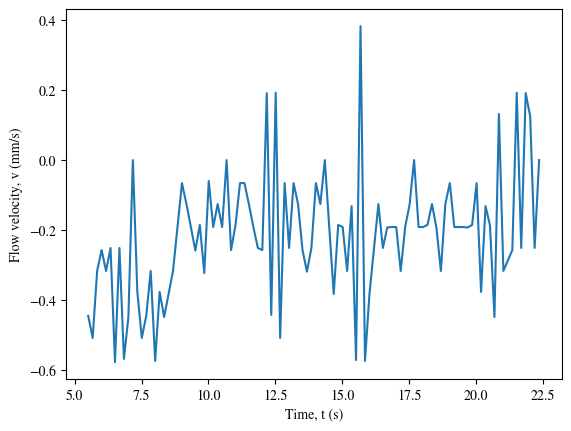

In [ ]:
plt.plot(v_mean)
plt.xlabel("Time, t (s)")
plt.ylabel("Flow velocity, v (mm/s)")

In [ ]:
v_mean.abs().to_frame("Velocity").to_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_flow-time.csv")

Plot the velocity over time for the four scans.

In [ ]:
folder = r"E:\WPM\04292024\flow_field_hand_track"
df_list = []
for i in range(4):
    df = pd.read_csv(os.path.join(folder, "beet_scan4_{:d}_flow-time.csv".format(i+1))).rename(columns={"Velocity": "v{:d}".format(i)})
    df["t"] -= df["t"].min()
    df_list.append(df.sort_values("t").set_index("t"))
dfall = pd.concat(df_list, names=["v1", "v2", "v3", "v4"], axis=1)

In [ ]:
df.sort_values(by="t")

,t,Velocity
0,0.000,0.445783
1,0.167,0.508982
2,0.334,0.317365
3,0.501,0.257485
4,0.668,0.317365
...,...,...
94,16.183,0.251497
95,16.350,0.191617
96,16.517,0.125749
97,16.684,0.251497


<Axes: >

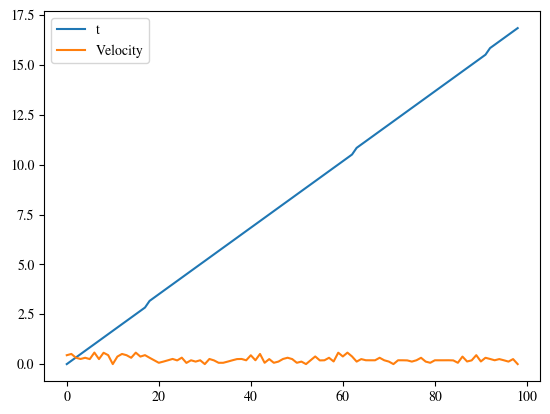

In [ ]:
df.sort_values(by="t").plot()

(0.0, 6.0)

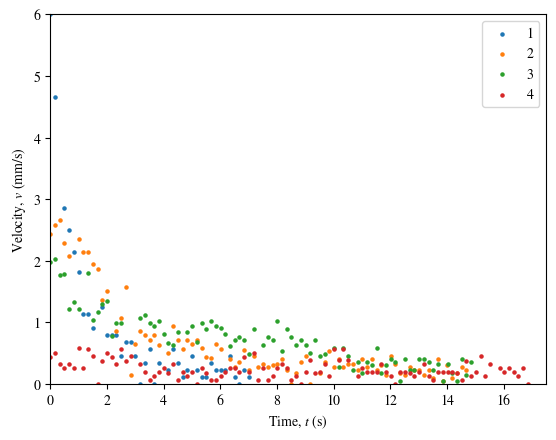

In [ ]:
for key in dfall:
    plt.scatter(dfall.index, dfall[key], s=5)
plt.legend([1,2,3,4])
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0,17.5])
plt.ylim([0,6])

### 3.2 Spatial variation

## Appendix A. Load video

In [ ]:
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # by default opencv reads images as BGR, here we convert to RGB to be compatible with matplotlib
    break

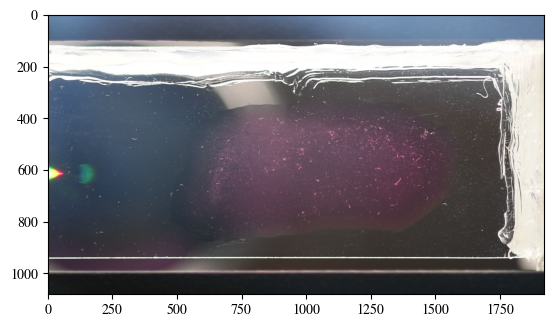

In [ ]:
plt.imshow(frame)

## Appendix B. Verify scanner speed

Since the scanner moves almost at a constant speed, a frame-by-frame tracking is an overkill. Instead, we can use two key frames at the beginning and the end of each scan, and infer the framewise location of the scanner, or the focus of the scanner. 

The key frame xy location is obtained from ImageJ and the frame number is obtained from MPC player (get time and convert to frame number).

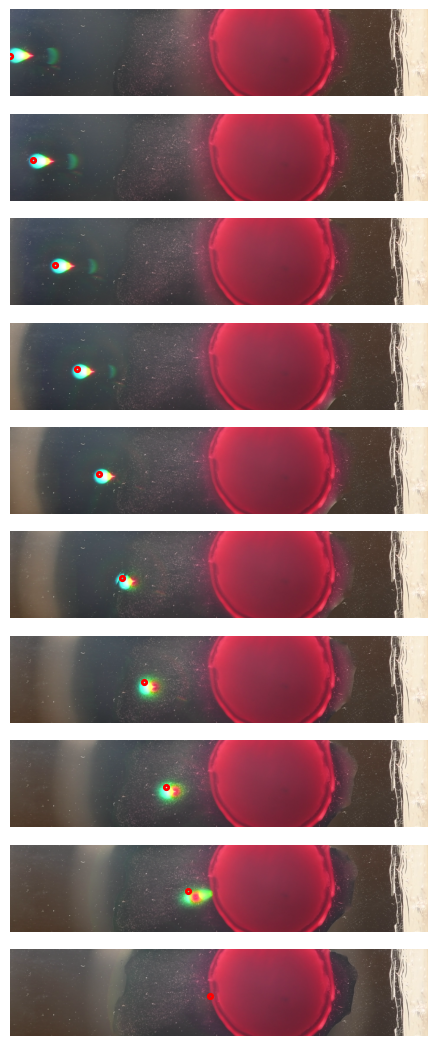

In [ ]:
# eye tracking 942@(1,614), 2099@(921,614)
# draw 10 pictures with dot indicator on raw image
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
i = 0
fps = 30
num_draw = 10
show = np.linspace(12.879*fps, 28.428*fps, endpoint=True, num=num_draw).astype("int")
x = np.linspace(1, 921, endpoint=True, num=num_draw)
y = np.ones(x.shape) * 614
count = 0
# initialize figure
fig, ax = plt.subplots(ncols=1, nrows=num_draw, figsize=(1980/300, 400*num_draw/300), dpi=100)
while True:
    ret, frame = cap.read()  
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    i += 1
    if i in show:
        ax[count].imshow(frame[400:800, :])
        ax[count].scatter(x[count], y[count]-400, s=10, facecolor=(0,0,0,0), edgecolor="red", linewidths=2)
        ax[count].axis("off")
        count += 1

The scanner can be approximated as moving at a constant speed.